In [390]:
using CSV, DataFrames, Plots, Suppressor, LsqFit, StatsPlots, Printf, LaTeXStrings, StatsBase

In [382]:
const fraction = .1

0.1

In [2]:
espectros = Vector{String}()
for (root, dir, files) in walkdir(".")
    try
        m = match.(r"(?<!Copia\sde\s)MOF\s?\d.*300\s700.*txt$", files) |> arr -> filter(!isnothing, arr) .|> l -> l.match
        joinpath.(root,m) .|> x -> push!(espectros,x)
    catch e 
        nothing;
    end
end


In [3]:
@suppress begin
    dfs = []
   df = CSV.File(espectros[12], skipto = 12) |> DataFrame
   push!(dfs,df)
end

1-element Vector{Any}:
 10000×43 DataFrame
   Row │ MOF 1 Air 300 700 nm 40 us Delta OD  Column2       Column3       Colu ⋯
       │ Float64                              Float64       Float64       Floa ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │                                 0.0  -0.00678485    0.00473154   -0.0 ⋯
     2 │                                 4.0  -0.0178972     0.00575815    0.0
     3 │                                 8.0  -0.00383729    0.000454337   0.0
     4 │                                12.0  -0.000517441  -0.000657262  -0.0
     5 │                                16.0  -0.00676877   -0.00281306    0.0 ⋯
     6 │                                20.0   0.00111519    0.00688019   -0.0
     7 │                                24.0  -0.000460973   0.00890735   -0.0
     8 │                                28.0  -0.000499482  -0.00274301    0.0
     9 │                                32.0  -0.00689717    0.00798296   -0.0

In [41]:
dfs = []
@suppress begin
    for espectro ∈ espectros
        nms = readlines(espectro)[3] |> x-> split(x,",") |> x-> match.(r"\d*\.", x) |> arr -> filter(!isnothing, arr) .|> l -> l.match[begin:end-1]
        prepend!(nms, ["t"])
        push!(nms, "drop")
        df = CSV.File(espectro, skipto = 12, header = String.(nms)) |> DataFrame 
        push!(dfs, (split(espectro,"/")[end],df))
    end
end

In [598]:
base = Dict(
    "MOF 1" => Dict(
        "Ar"=> Set(),
        "O2" => Set(),
        "Aire" => Set()
        ),
    "MOF 2" =>Dict(
        "Ar"=> Set(),
        "O2" => Set(),
        "Aire" => Set()
        ),
    "MOF 3" =>Dict(
        "Ar"=> Set(),
        "O2" => Set(),
        "Aire" => Set()
        )
)

Dict{String, Dict{String, Set{Any}}} with 3 entries:
  "MOF 1" => Dict("Aire"=>Set(), "Ar"=>Set(), "O2"=>Set())
  "MOF 2" => Dict("Aire"=>Set(), "Ar"=>Set(), "O2"=>Set())
  "MOF 3" => Dict("Aire"=>Set(), "Ar"=>Set(), "O2"=>Set())

In [596]:
data = base |> deepcopy
for (name, df) ∈ dfs
    for mof in keys(data)
            if occursin(mof, name)
                if occursin("O2",name)
                    push!(data[mof]["O2"], (name, df))
                elseif occursin("Ar",name)
                    push!(data[mof]["Ar"], (name,df))
                else
                    push!(data[mof]["Aire"], (name,df))
                end
        end
    end
end

In [571]:
d = data["MOF 1"]
tp = []
for (tr,tpl) ∈ pairs(d)
    name,df = first(tpl)
    t,y = df.t[decay:end], df."460"[decay:end]
    ind = findfirst(abs.(y .- 0.05 * maximum(y) .< .01) )
    p = Plots.scatter(t,y)
    vline!([t[ind]])

    push!(tp,p)
end


In [570]:
plot(tp...)

In [599]:
approx_lifetime(t::T, y::T) where T <: Vector{Float64}  = findfirst(abs.(y .- 0.05 * maximum(y) .< .01) ) |> idx -> t[idx]

function fit_model(name :: String , df :: DataFrame) :: Tuple
    ts = match(r"\d*(?=\s?us)",name).match
  
    model(t,p) = p[1] .+ p[2] * exp.(-t*p[3])
    maxIter = 1000
    decay = (df.t |> length |> l -> ceil(l*fraction) |> Int) + 10
    t, y = df.t[decay:end], df."460"[decay:end]
    al = 1 / approx_lifetime(t,y)
    initial_parameters = [0.1 ,maximum(y), al]
    fit = curve_fit(model, t, y, initial_parameters; maxIter = maxIter)
    t,y, name, fit.param, parse(Int64, ts)
end
    




fit_model (generic function with 2 methods)

In [590]:
fiteos = base |> deepcopy

for mof ∈ keys(data)
    for treat ∈ keys(data[mof])
        for elem ∈ data[mof][treat]
            name, df = elem
            tpl = fit_model(name, df)
            push!(fiteos[mof][treat], tpl)
        end
    end
end

In [591]:
gf = Dict(
    "Aire" => Dict(
        "lifetimes" => [],
        "amplitudes" => []
    ),
    "O2" => Dict(
        "lifetimes" => [],
        "amplitudes" => []
    ),
    "Ar" => Dict(
        "lifetimes" => [],
        "amplitudes" => []
    )
)


for (n, mof) ∈ enumerate(keys(fiteos))
    for treat ∈ keys(fiteos[mof])
        name, fit_param, error = first(fiteos[mof][treat])
        if !ismissing(error)
            insert!(gf[treat]["lifetimes"], n, fit_param[3])
            insert!(gf[treat]["amplitudes"], n, fit_param[2])
        else
            insert!(gf[treat]["lifetimes"], n, nothing)
            insert!(gf[treat]["amplitudes"], n, nothing)
        end
    end
end

                
        

In [600]:
lifetime_plot = Plots.plot(xlabel = "MOF", ylabel = "Lifetime")
for treat ∈ gf |> keys
    scatter!(lifetime_plot, 1:length(gf[treat]["lifetimes"]) |> collect, gf[treat]["lifetimes"], label = treat )
end

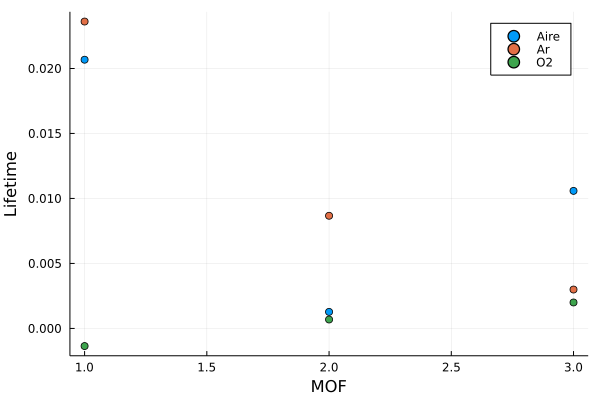

In [601]:
lifetime_plot

In [592]:
fiteos

Dict{String, Dict{String, Set{Any}}} with 3 entries:
  "MOF 1" => Dict("Aire"=>Set([([4036.0, 4040.0, 4044.0, 4048.0, 4052.0, 4056.0…
  "MOF 2" => Dict("Aire"=>Set([([100900.0, 101000.0, 101100.0, 101200.0, 101300…
  "MOF 3" => Dict("Aire"=>Set([([4036.0, 4040.0, 4044.0, 4048.0, 4052.0, 4056.0…

In [593]:
for mof in keys(data)
    for treat in keys(data[mof])
        name, df = first(data[mof][treat])
        t,y, name ,params,ts = fit_model(name,df)
        println("$ts => $name")
        lfpp = Plots.plot(t,y, title = name[begin:end-3], label = "data")
        scatter!(lfpp, t,model(t, params), label = "fit")
        savefig(lfpp,"plots/con_params_calculados/p_$(name[begin:end-4])")
    end
end

40 => MOF 1 Air 300 700 nm 40 us Delta OD.txt
400 => MOF 1 PBS Ar 300 700 nm 400us Delta OD 10 disparos.txt
10 => MOF 1 O2 300 700 nm 10 us Delta OD.txt
40 => MOF 2 Air 300 700 nm 40 us Delta OD.txt
400 => MOF 2 PBS Ar 300 700 nm 400us Delta OD 5 disparos.txt
10 => MOF 2 O2  300 700 nm 10 us Delta OD.txt
40 => MOF 3 Air 300 700 nm 40 us Delta OD.txt
400 => MOF 3 PBS Ar 300 700 nm 400us Delta OD 5 disparos.txt
10 => MOF 3 O2 300 700 nm 10 us Delta OD.txt
